### DESC Sprint Week ELAsTiCC Tutorial Demo 1

## Reading SNANA FITS files with the elasticc2_snana_reader library

If you already know the SNANA format, then you may have your own way of reading these.

If not, download `read_snana.py` from  https://github.com/LSSTDESC/elasticc/blob/lib_elasticc2/lib_elasticc2/read_snana.pyhttps://github.com/LSSTDESC/elasticc/blob/lib_elasticc2/lib_elasticc2/read_snana.py

If you are running on NERSC, this library will magically look in the right place.  If you've downloaded the SNANA FITS files somewhere else, you need to do one of two things.  First, you can set the `TD` environment varaiable to the parent directory of the directory named `ELASTICC2` which has subdirectories for the different SNANA models.  Alternatively, you can pass the path (_including_ the `ELASTICC2` part) of the ELASTICC2 directory to the `elasticc2_snana_reader` constructor.

The data are divided up by object class name (really, SNANA model-- not to be confused with the ELAsTiCC2 taxonomy classID).  Once you've instantiated a `elasticc2_snana_reader` object (see below), you can get the list of available object class names from its `obj_class_names` property.  For further things you can do, see below, and/or read the docstrings of the methods in `read_snana.py`.

In [1]:
%matplotlib inline

import sys
import os
import math
import pathlib
import logging

import numpy
import matplotlib
from matplotlib import pyplot

# Need to add the lib_elasticc2 directory to the PYTHONPATH so that we
#  can import it.  (Or, whatever directory you've saved the
#  read_snana.py file to.)
libdir = pathlib.Path( os.getcwd() ).parent.parent / "lib_elasticc2"
sys.path.insert( 0, str(libdir) )
from read_snana import elasticc2_snana_reader

# Make a logger so that we can print out timings and things like that
_logger = logging.getLogger("main")
if not _logger.hasHandlers():
    _logout = logging.StreamHandler( sys.stderr )
    _logger.addHandler( _logout )
    _logout.setFormatter( logging.Formatter( f'[%(asctime)s - %(levelname)s] - %(message)s',
                                             datefmt='%Y-%m-%d %H:%M:%S' ) )
_logger.setLevel( logging.INFO )
_logger.info( "Testing" )

# Make a random number generator.  If you 
#  want reproducibility, set the seed
#  to something other than None.
# _random_seed = None
_random_seed = 42
rng = numpy.random.default_rng( seed=_random_seed )


[2024-11-18 11:53:04 - INFO] - Testing


In [4]:
# Create a reader for further use
# It needs to know where to find the ELAsTiCC2 SNANA FITS files
# If on NERSC, it will default to the right place, and you don't need
#   to put anything here.
# If you have set the TD environment variable, it will look in
#   the ELASTICC2 subdirectory of $TD
# Otherewise, explicitly give the path to the constructor
# esr = elasticc2_snana_reader( "/data/raknop/ELASTICC2" )

# To read the training set instead of the test set, you have to 
# give it both the directory and a dir_prefix of "ELASTICC2_TRAIN_02_". 
# The directory on NERSC is 
# /global/cfs/cdirs/lsst/www/DESC_TD_PUBLIC/ELASTICC/ELASTICC2_TRAINING_SAMPLE_2

esr = elasticc2_snana_reader( "/data/rknop/ELASTICC2_TRAIN", dir_prefix="ELASTICC2_TRAIN_02_" )
# esr = elasticc2_snana_reader( "/global/cfs/cdirs/lsst/www/DESC_TD_PUBLIC/ELASTICC/ELASTICC2_TRAINING_SAMPLE_2",
#                               dir_prefix="ELASTICC2_TRAIN_02_" )

# esr = elasticc2_snana_reader()

In [5]:
# Define a function for plotting lightcurves.  We're going to use
# this lots below, and this saves repeated code in cells
def plot_ltcv( ltcv, figsize=(6,6), multiplots=False ):
    plotcolors = { 'u': '#cc0ccc', 
                   'g': '#00cc44', 
                   'r': '#cc0000', 
                   'i': '#ff4400', 
                   'z': '#886600',
                   'Y': '#442200' }
    knownbands = ltcv['BAND'].unique()
    if any( b not in plotcolors.keys() for b in knownbands ):
        _logger.warning( f"Unknown bands not plotted: {[b for b in knownbands if b not in plotcolors.keys()]}" )
    bandstoplot = [ b for b in plotcolors.keys() if b in knownbands ]

    if multiplots:
        nrows = math.ceil( len(bandstoplot) / 2 )
        if figsize is None:
            width = 9 if width is None else width
            figsize = ( width, width/3. * nrows )
        fig, axes = pyplot.subplots( nrows, 2, figsize=figsize, tight_layout=True, sharex='all' )
        axes = axes.flatten()
    else:
        if figsize is None:
            width = 9 if width is None else width
            figsize = ( width, width/2. )
        fig, axes = pyplot.subplots( 1, 1, figsize=figsize, tight_layout=True )
        axes = [ axes ]
    axesdex = 0

    for band in bandstoplot:
        bandltcv = ltcv[ ltcv['BAND'] == band ]
        axes[axesdex].errorbar( bandltcv['MJD'], bandltcv['FLUXCAL'], yerr=bandltcv['FLUXCALERR'],
                                color=plotcolors[band], linestyle='None', marker='o',
                                label=band )
        if multiplots: axesdex += 1

    for i, axis in enumerate( axes ):
        if i >= len(bandstoplot):
            axis.set_visible( False )
        else:
            ymin, ymax = axis.get_ylim()
            if ymin > 0:
                axis.set_ylim( 0, ymax )
            axis.set_title( f"SN {snid} at z={snia_truth[ snia_truth['SNID'] == snid ]['ZCMB'].values[0]:.3f}" )
            axis.set_xlabel( r"MJD" )
            axis.set_ylabel( r"Flux" )
            axis.tick_params( axis='both', reset=True )
            axis.legend()

    # In the jupyter script environment, the plot gets shown
    #   inline automatically.  If you're running this
    #   from the command line, you might need to do
    #   fig.show().  You might also want to do something
    #   like fig.savefig(filename).  So, return the Figure
    #   to make these things possible.
    # One side-effect of this is that your figure may be
    #   shown *twice* in your jupyter notebook; once for
    #   the plotting above, and once again if the call
    #   to plot_ltcv is the last command in the cell,
    #   because jupyter by default displays the value
    #   of the last expression in each cell.  Add a ;
    #   to the end of your plot_ltcv cell to supporess
    #   this in jupyter.
    return fig


In [6]:
# See what models are known:
print( "\n".join( esr.obj_class_names ) )

KN_B19
SNIa-SALT3


In [7]:
# Let's read the HEAD files of the SNIa-SALT3 so we can get a list of known objects
# By default, it returns Polars DataFrames.  Some people think that format has 
#   advantages over Pandas.  Here, return Pandas, because that's a better-known
#   format.
# This can take a little while (~10-40 seconds for a large model like SNIa-SALT3,
#   depending on filesystem performanace and whether you've recently read these
#   HEAD files or not; the library caches the most recently read set of HEAD files.)
_logger.info( "Reading HEAD files..." )
snia_head = esr.get_head( 'SNIa-SALT3', return_format='pandas' )
_logger.info( "...done reading HEAD files." )
print( f"Read {len(snia_head)} SNIa-SALT3 records." )

[2024-11-18 11:53:34 - INFO] - Reading HEAD files...
[2024-11-18 11:53:34 - INFO] - Reading HEAD files from /data/rknop/ELASTICC2_TRAIN/ELASTICC2_TRAIN_02_SNIa-SALT3
[2024-11-18 11:53:39 - INFO] - ...done reading HEAD files.


Read 172484 SNIa-SALT3 records.


In [8]:
# Let's also read the truth file so that we can do things like
#    filter on redshift.  This also takes ~10-30 seconds for
#    a large model like SNIa-SALT3.  It does not cache.
_logger.info( "Reading truth file..." )
snia_truth = esr.get_object_truth( 'SNIa-SALT3', return_format='pandas' )
_logger.info( "...done reading truth file." )
print( f"Read {len(snia_truth)} object truth records for SNIa-SALT3" )

[2024-11-18 11:53:39 - INFO] - Reading truth file...
[2024-11-18 11:53:39 - INFO] - Reading /data/rknop/ELASTICC2_TRAIN/ELASTICC2_TRAIN_02_SNIa-SALT3/ELASTICC2_TRAIN_02_SNIa-SALT3.DUMP
[2024-11-18 11:53:40 - INFO] - ...done reading truth file.


Read 172484 object truth records for SNIa-SALT3


In [9]:
print( "\n".join(snia_head.columns) )

SNID
RA
DEC
SNTYPE
NOBS
PTROBS_MIN
PTROBS_MAX
MWEBV
MWEBV_ERR
REDSHIFT_HELIO
REDSHIFT_HELIO_ERR
REDSHIFT_FINAL
REDSHIFT_FINAL_ERR
VPEC
VPEC_ERR
HOSTGAL_NMATCH
HOSTGAL_NMATCH2
HOSTGAL_OBJID
HOSTGAL_FLAG
HOSTGAL_PHOTOZ
HOSTGAL_PHOTOZ_ERR
HOSTGAL_SPECZ
HOSTGAL_SPECZ_ERR
HOSTGAL_RA
HOSTGAL_DEC
HOSTGAL_SNSEP
HOSTGAL_DDLR
HOSTGAL_CONFUSION
HOSTGAL_LOGMASS
HOSTGAL_LOGMASS_ERR
HOSTGAL_LOGSFR
HOSTGAL_LOGSFR_ERR
HOSTGAL_LOGsSFR
HOSTGAL_LOGsSFR_ERR
HOSTGAL_COLOR
HOSTGAL_COLOR_ERR
HOSTGAL_ELLIPTICITY
HOSTGAL_OBJID2
HOSTGAL_SQRADIUS
HOSTGAL_OBJID_UNIQUE
HOSTGAL_ZPHOT_Q000
HOSTGAL_ZPHOT_Q010
HOSTGAL_ZPHOT_Q020
HOSTGAL_ZPHOT_Q030
HOSTGAL_ZPHOT_Q040
HOSTGAL_ZPHOT_Q050
HOSTGAL_ZPHOT_Q060
HOSTGAL_ZPHOT_Q070
HOSTGAL_ZPHOT_Q080
HOSTGAL_ZPHOT_Q090
HOSTGAL_ZPHOT_Q100
HOSTGAL_MAG_u
HOSTGAL_MAG_g
HOSTGAL_MAG_r
HOSTGAL_MAG_i
HOSTGAL_MAG_z
HOSTGAL_MAG_Y
HOSTGAL_MAGERR_u
HOSTGAL_MAGERR_g
HOSTGAL_MAGERR_r
HOSTGAL_MAGERR_i
HOSTGAL_MAGERR_z
HOSTGAL_MAGERR_Y
HOSTGAL2_OBJID
HOSTGAL2_FLAG
HOSTGAL2_PHOTOZ
HOSTGAL2_PHOT

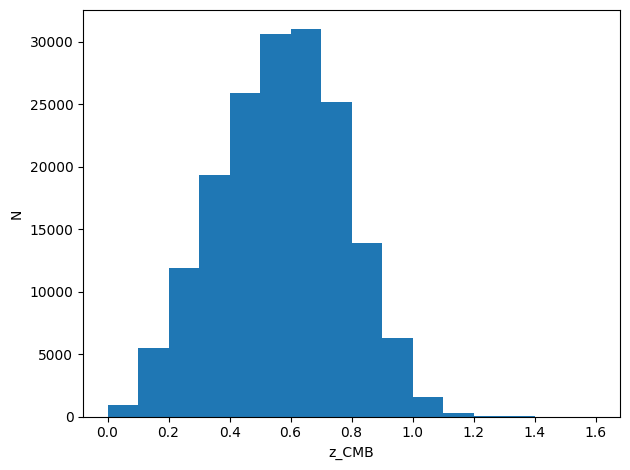

In [10]:
# Make a histogram of redshifts
fig, axes = pyplot.subplots( 1, 1, tight_layout=True )
axes.hist( snia_truth['ZCMB'], bins=numpy.arange( 0, 1.7, 0.1 ) )
axes.set_xlabel( r"z_CMB" )
axes.set_ylabel( r"N" )
# axes.set_yscale('log')

_;  # (Just to suppress gratuitous output.)

In [11]:
# Let's pick a random SN betwen z=0.1 and 0.2 to plot
zp1t2 = snia_truth[ ( snia_truth['ZCMB'] >= 0.1 ) & ( snia_truth['ZCMB'] < 0.2 ) ].reset_index()

# NOTE : have to be careful with Pandas, it sometimes does things you don't want it
# to do.  For instance,
#   snid = zp1t2.iloc[ rng.integers( 0, len(zp1t2) ) ]['SNID']
# should, return the same as the line below, or so you would think.
# But, if you use iloc, pandas seems to convert all numeric types
# to float64!  This is bad, because SNID is a 64-bit integer, and
# float64 only has 53 bits of precision in the mantissa. As such, you
# could very easily end up losing the actual value of the integer as it 
# gets rounded off, if it's big enough.  Always look at Pandas
# data types and be suspicious of what it's doing.
snid = zp1t2['SNID'][ rng.integers( 0, len(zp1t2) ) ]
print( f"Randomly chose {snid}, (type: {type(snid)})" )



Randomly chose 60368025, (type: <class 'numpy.int64'>)


[2024-11-18 11:53:43 - INFO] - Reading lightcurve from /data/rknop/ELASTICC2_TRAIN/ELASTICC2_TRAIN_02_SNIa-SALT3/ELASTICC2_TRAIN_02_NONIaMODEL0-0038_PHOT.FITS.gz


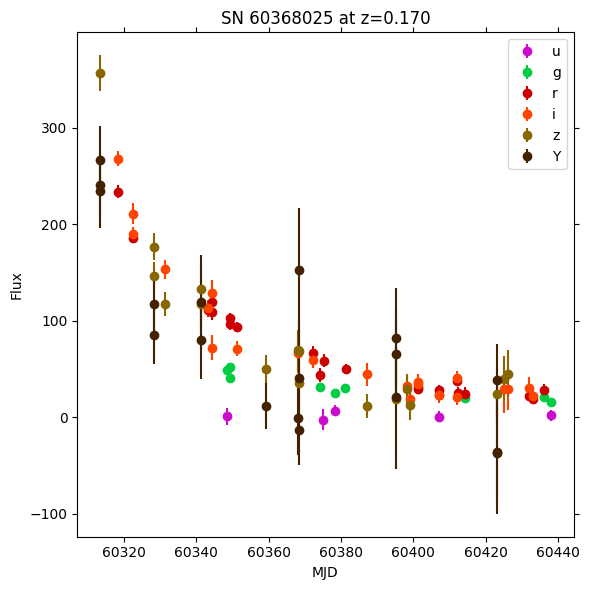

In [12]:
#...and plot it

ltcv = esr.get_ltcv( 'SNIa-SALT3', snid, return_format='pandas' )
plot_ltcv( ltcv );

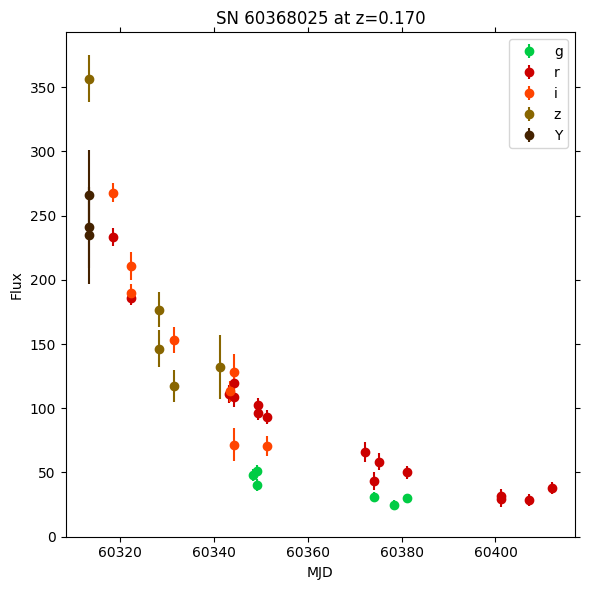

In [13]:
# That's too much forced photometry.  We could just manually crop down the
# limits of the x axis, but for demo purposes, let's select out just the
# points that counted as "detected":

detected_ltcv = ltcv[ ( ltcv['PHOTFLAG'] & esr.photflag_detect ) !=0 ]
plot_ltcv( detected_ltcv );

#...which should make you feel a little bit queasy about the WFD cadence...

In [14]:
# Suppose I wanted to find a supernova with "lots" of
# detections.  For this, we need to read all the lightcurves.
# Remember there are 1.7 million SNe Ia.  Reading all of those
# lightcurves from the gzipped PHOT files will take a long time
# (minutes and minutes).
#
# However, we can get just a subset of the lightcurves.  The
# PHOT files are divided into 40 separate files.  We can get
# all of the lightcurves from just one of them, and that won't
# be too many; reading one PHOT file will just take 10-30
# of seconds (depending on filesystem performance).
#
# elasticc2_snana_reader.get_all_ltcvs() will normally take
# the time necessary to read all of the phot files, but
# you can give it the parameter file_num=<num>, where <num>
# is between 1 and 40, to get a subset of the files.

_logger.info( "Getting SNe Ia lightcurves from file 1..." )
sneIa_ltcvs = esr.get_all_ltcvs( 'SNIa-SALT3', file_num=1, return_format='pandas' )
_logger.info( "...done" )


[2024-11-18 11:53:45 - INFO] - Getting SNe Ia lightcurves from file 1...
[2024-11-18 11:53:45 - INFO] - Reading /data/rknop/ELASTICC2_TRAIN/ELASTICC2_TRAIN_02_SNIa-SALT3/ELASTICC2_TRAIN_02_NONIaMODEL0-0001_PHOT.FITS.gz...
[2024-11-18 11:53:46 - INFO] - ...assigning SNID
[2024-11-18 11:53:46 - DEBUG] - Concatenating 1 dataframes
[2024-11-18 11:53:46 - DEBUG] - Sorting
[2024-11-18 11:53:46 - DEBUG] - Returning
[2024-11-18 11:53:46 - INFO] - ...done


In [15]:
# Try to get a random object with z=[0.1,0.2) and "lots" detections.

# Play some pandas games.  We want the count of detections for each object, and then
# we want to join that to the truth table.  The result of that join will crop
# down the truth table to just the object that are in file 1 (because we're doing
# an inner join), and will add the column 'ndetect' with the number of
# detections.  We can then filter on that and the redshift range and pick 
# out a supernovae with lots of detections.

detcounts = ( sneIa_ltcvs[ ( sneIa_ltcvs['PHOTFLAG'] 
                           & esr.photflag_detect ) != 0 ]
              .groupby( 'SNID' ).agg('count')['MJD']
              .reset_index().rename( {'MJD': 'ndetect'}, axis=1 ) )
truth_file1_withcounts = snia_truth.join( detcounts.set_index("SNID"), on='SNID', how='inner' )
subset = truth_file1_withcounts[ ( truth_file1_withcounts['ZCMB'] >= 0.1 ) & 
                                 ( truth_file1_withcounts['ZCMB'] < 0.2 ) & 
                                 ( truth_file1_withcounts['ndetect'] > 30 ) ]
snid = subset['SNID'].values[ rng.integers( 0, len(subset) ) ]
print( f"Picked SN {snid} with {subset[ subset['SNID']==snid ]['ndetect'].values[0]} detections" )

Picked SN 72179491 with 48 detections


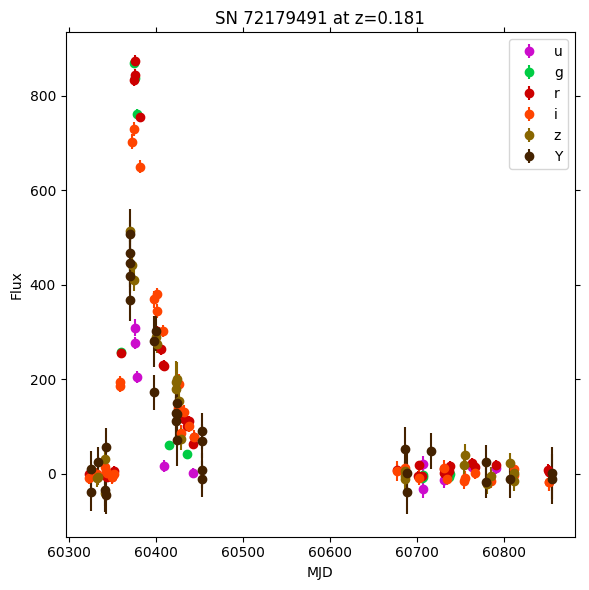

In [16]:
# We could extract the lightcurve with esr.get_ltcv() as we did before.  However,
# we already have it in memory in the sneIa_ltcvs variable we read earlier, so 
# instead play Pandas games to extract the lightcurve

ltcv = sneIa_ltcvs[ sneIa_ltcvs['SNID'] == snid ]
plot_ltcv( ltcv );


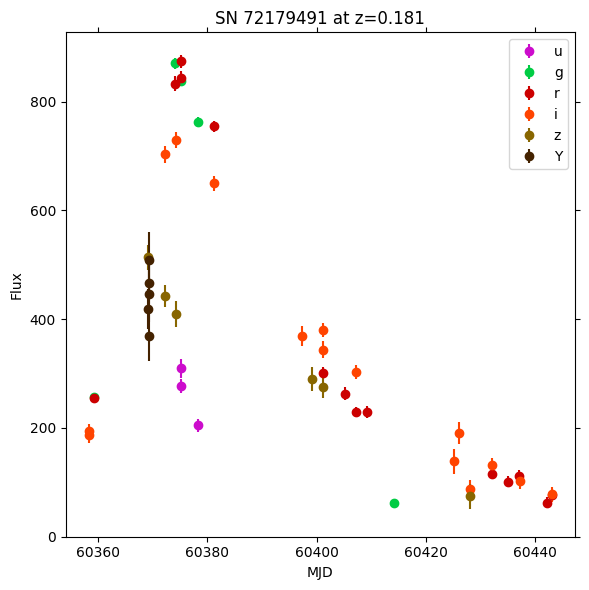

In [17]:
# Do the same thing of just plotting the detected points
detected_ltcv = ltcv[ ( ltcv['PHOTFLAG'] & esr.photflag_detect ) !=0 ]
plot_ltcv( detected_ltcv );


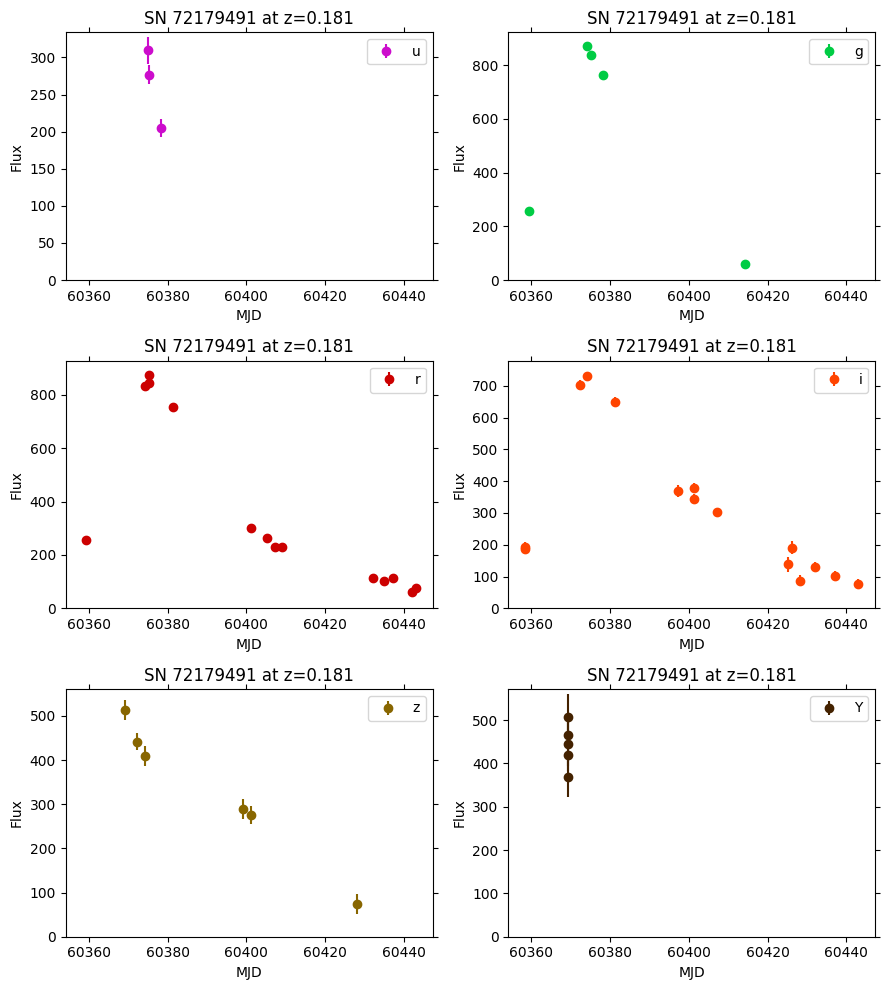

In [18]:
# This would probably look better with different bands in different plots....
plot_ltcv( detected_ltcv, figsize=(9, 10), multiplots=True );